## Name: {Claire Zhou}
## Section: {02}

# Lab 3: Regularization for Logistic Regression Models

To help develop your understanding of the effect of regularization on logistic regression models, in this lab we will experiment with regularization by adjusting the level of shrinkage we apply to the model coefficients. We'll look at how the coefficients and the goodness-of-fit (performance) of the model changes as the shrinkage changes. 

## Tools

#### Libraries:

- sklearn: for model training  
- pandas: for data processing  
- plotnine: for visualization

#### Datasets:

I'll suggest a dataset here, but feel free to import some of your own and experiment. **sklearn.datasets** is a good place to start.

- Wine dataset

## Logistic Regression - No Regularization

To start, we will fit a logistic regression model without regularization and examine the coefficients and model fit.

In [2]:
# Here are the libraries we will use
import numpy as np
import pandas as pd
from plotnine import ggplot, geom_point, aes, geom_line, theme, theme_bw, ylab, xlab, geom_bar, element_text

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_wine
from sklearn.metrics import confusion_matrix, precision_score, recall_score, log_loss

### As usual, load the data and take a look at it

In [3]:
# Load the data and look at the dictionary
wine = load_wine()
df_wine = pd.DataFrame(data=wine.data, columns=wine.feature_names)
df_wine['y'] = wine.target
df_wine = df_wine[df_wine['y']<2] # Only do 2-class problem {0,1}

X = df_wine.drop('y', axis=1)
y = df_wine['y']
print(f"{len(X)} records for classes {{0,1}} from {len(wine.data)} records")
X.head(2)

130 records for classes {0,1} from 178 records


,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0


---

**1. Split the data into train and test sets**

In [4]:
#your code goes here
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

<details>
<summary>Solution</summary>
<pre>
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)
</pre>
</details>

---

**2. Fit a logistic regression model without regularization**

Use parameters: penalty=None, solver='lbfgs', max_iter=200. Train on X_train, y_train. 

In [5]:
# Your code here
lg = LogisticRegression(penalty=None, solver='lbfgs', max_iter=200)
lg.fit(X_train,y_train)

LogisticRegression(max_iter=200, penalty=None)

<details>
<summary>Solution</summary>
<pre>
lg = LogisticRegression(penalty=None, solver='lbfgs', max_iter=200)
lg.fit(X_train,y_train)
</pre>
</details>

---

**3. Assess the model performance on the training AND the testing set using Accuracy and Log Loss**

Accuracy is just the proportion of observations that are predicted correctly. By default, `sklearn` uses a cutoff of probability cutoff of 0.5 (equivalent to just using a cutoff of 0 for the linear equation $X\beta$). Log loss here is the negative log-likelihood we talked about in class, which means that a smaller number is **better**.

In [6]:
# Your code here
print(f"Accuracy: Train {100*lg.score(X_train, y_train):.0f}%, Test {100*lg.score(X_test, y_test):.0f}%")
y_proba_train = lg.predict_proba(X_train)[:,1]
y_proba_test = lg.predict_proba(X_test)[:,1]
print(f"Log loss: Train {log_loss(y_train, y_proba_train):.2f}, Test {log_loss(y_test, y_proba_test):.2f}")

Accuracy: Train 100%, Test 92%
Log loss: Train 0.00, Test 2.77


---

### Looking at the coefficients

We should visualize the coefficients in some way to get an idea of their size so we can then compare them after we fit another model with regularization.

In [7]:
lg_beta = lg.coef_[0]

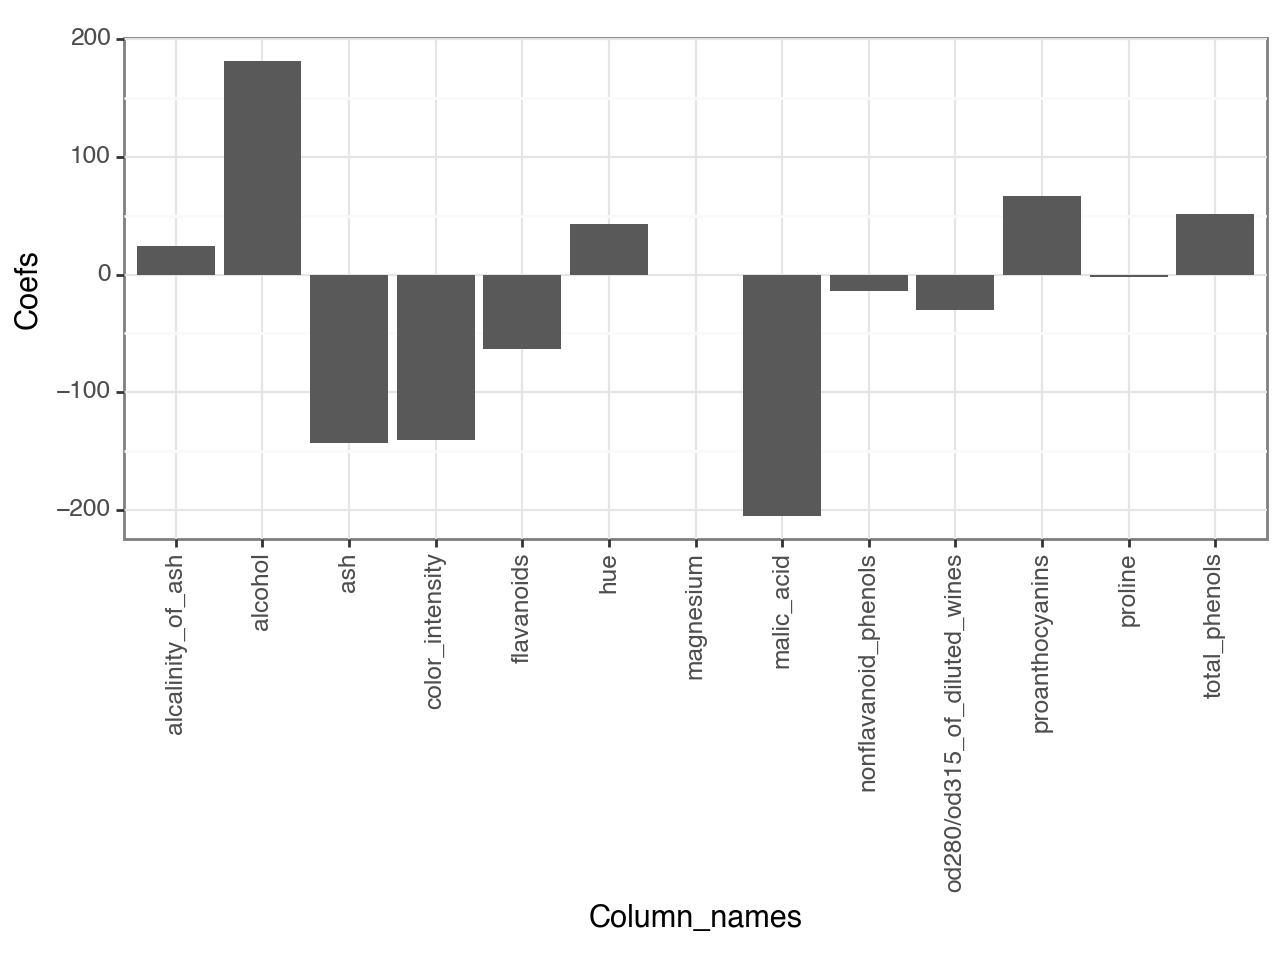

<Figure Size: (640 x 480)>

In [8]:
plot_data = pd.DataFrame({'Column_names':X.columns, 'Coefs':lg_beta})

(
 ggplot(data = plot_data) +
    geom_bar(stat = 'identity', mapping = aes(x = 'Column_names', y = 'Coefs')) +
    theme_bw()+
    theme(axis_text_x = element_text(angle = 90))
)

---

### Normalize variables, retrain, and look at the coefficients and metrics

When we do regularized regression we have to normalize our features. Let's do this now, but remember that when you normalize your testing data, you have to use the mean and standard deviation from your training data. Common rookie mistake is to normalize the data before splitting it into training, validation and test sets.

In [9]:
mus = X_train.mean(axis = 0)
sds = X_train.std(axis = 0)

for col in X.columns:
    X_train[col] = (X_train[col] - mus[col])/sds[col]
    X_test[col] = (X_test[col] - mus[col])/sds[col]

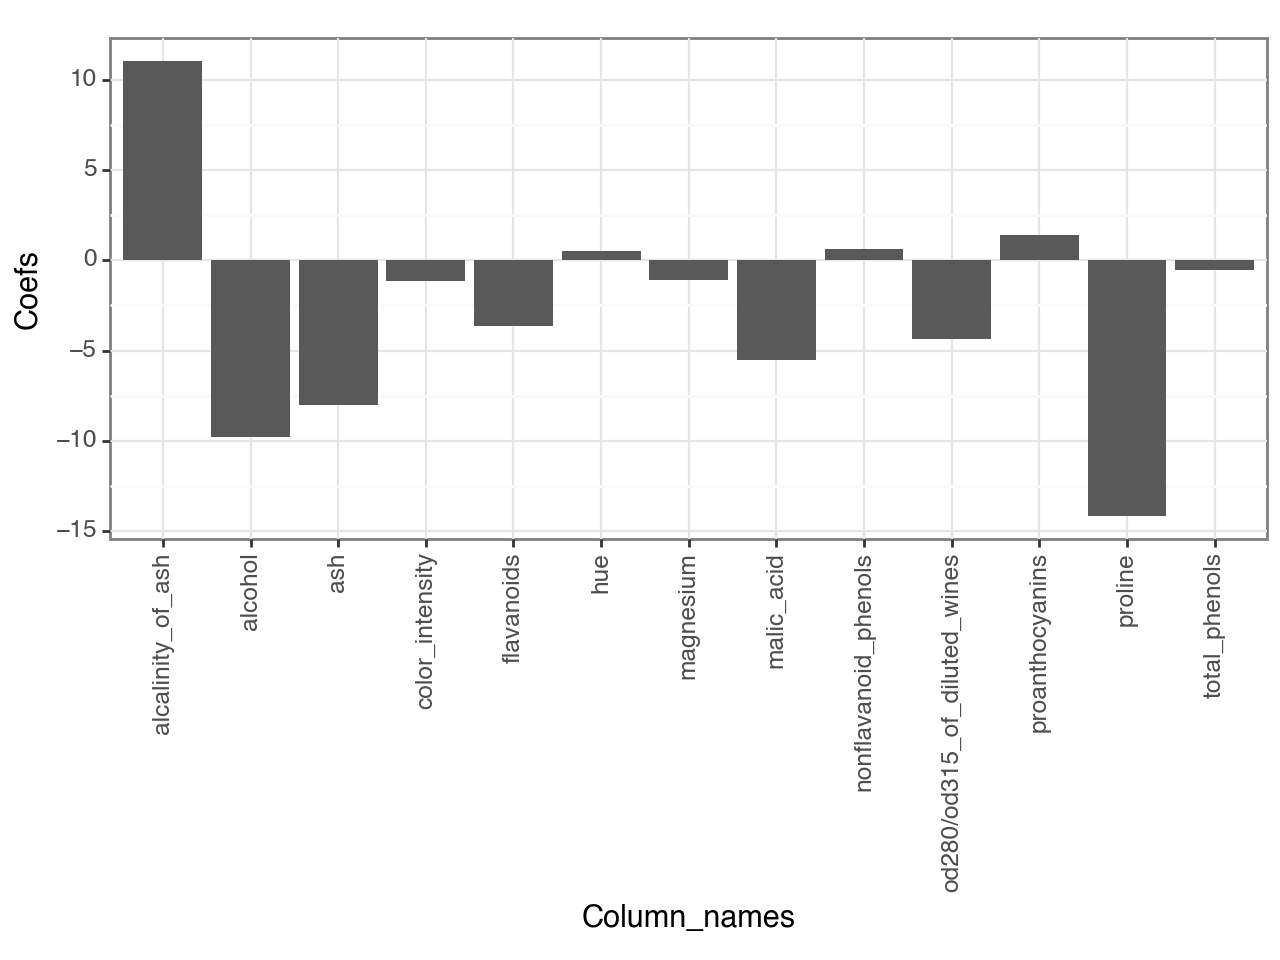

<Figure Size: (640 x 480)>

In [10]:
lg = LogisticRegression(penalty=None, solver='lbfgs')
lg.fit(X_train, y_train)
lg_beta = lg.coef_[0]
plot_data = pd.DataFrame({'Column_names':X.columns, 'Coefs':lg_beta})

(
 ggplot(data = plot_data) +
    geom_bar(stat = 'identity', mapping = aes(x = 'Column_names', y = 'Coefs')) +
    theme_bw()+
    theme(axis_text_x = element_text(angle = 90))
)

In [11]:
print(f"Accuracy: Train {100*lg.score(X_train, y_train):.0f}%, Test {100*lg.score(X_test, y_test):.0f}%")
y_proba_train = lg.predict_proba(X_train)[:,1]
y_proba_test = lg.predict_proba(X_test)[:,1]
print(f"Log loss: Train {log_loss(y_train, y_proba_train):.2f}, Test {log_loss(y_test, y_proba_test):.2f}")

Accuracy: Train 100%, Test 100%
Log loss: Train 0.00, Test 0.00


## Logistic Regression - With Regularization

Now let's add regularization to our model. There are two types of penalties we can add, L1 and L2, that will affect the model coefficients (and performance) differently. There is also a tuning parameter, $\lambda$ that we can tune which will adjust the level of shrinkage to our model. 

First, note that when we fit a regularized logistic model, our features must be normalized. We did this in the above step.

Now let's just choose a value for $\lambda$.

In [12]:
"""
sklearn says LogisticRegression arg C is "Inverse of regularization strength...
smaller values specify stronger regularization"
"""
lmbda=.1

---

**1. Fit a model with L1 regularization to the training set.**

In [13]:
lg = LogisticRegression(C=1/lmbda, penalty='l1', solver='liblinear', max_iter=1000)
# your code here
lg.fit(X_train, y_train)

LogisticRegression(C=10.0, max_iter=1000, penalty='l1', solver='liblinear')

<details>
<summary>Solution</summary>
<pre>
lg.fit(X_train, y_train)
</pre>
</details>

---

**2. Now look at the scores for the model? How do they compare to the unregularized model you fit above?**

In [14]:
# Your code here
print(f"Accuracy: Train {100*lg.score(X_train, y_train):.0f}%, Test {100*lg.score(X_test, y_test):.0f}%")
y_proba_train = lg.predict_proba(X_train)[:,1]
y_proba_test = lg.predict_proba(X_test)[:,1]
print(f"Log loss: Train {log_loss(y_train, y_proba_train):.2f}, Test {log_loss(y_test, y_proba_test):.2f}")

Accuracy: Train 100%, Test 100%
Log loss: Train 0.00, Test 0.01


<details>
<summary>Solution</summary>
<pre>
print(f"Accuracy: Train {100*lg.score(X_train, y_train):.0f}%, Test {100*lg.score(X_test, y_test):.0f}%")
y_proba_train = lg.predict_proba(X_train)[:,1]
y_proba_test = lg.predict_proba(X_test)[:,1]
print(f"Log loss: Train {log_loss(y_train, y_proba_train):.2f}, Test {log_loss(y_test, y_proba_test):.2f}")
</pre>
</details>

### It's very close to the unregularized model fitted above.

---

**3. Now look at the coefficients and compare to the unregularized model you fit above. How are they different? Why?**

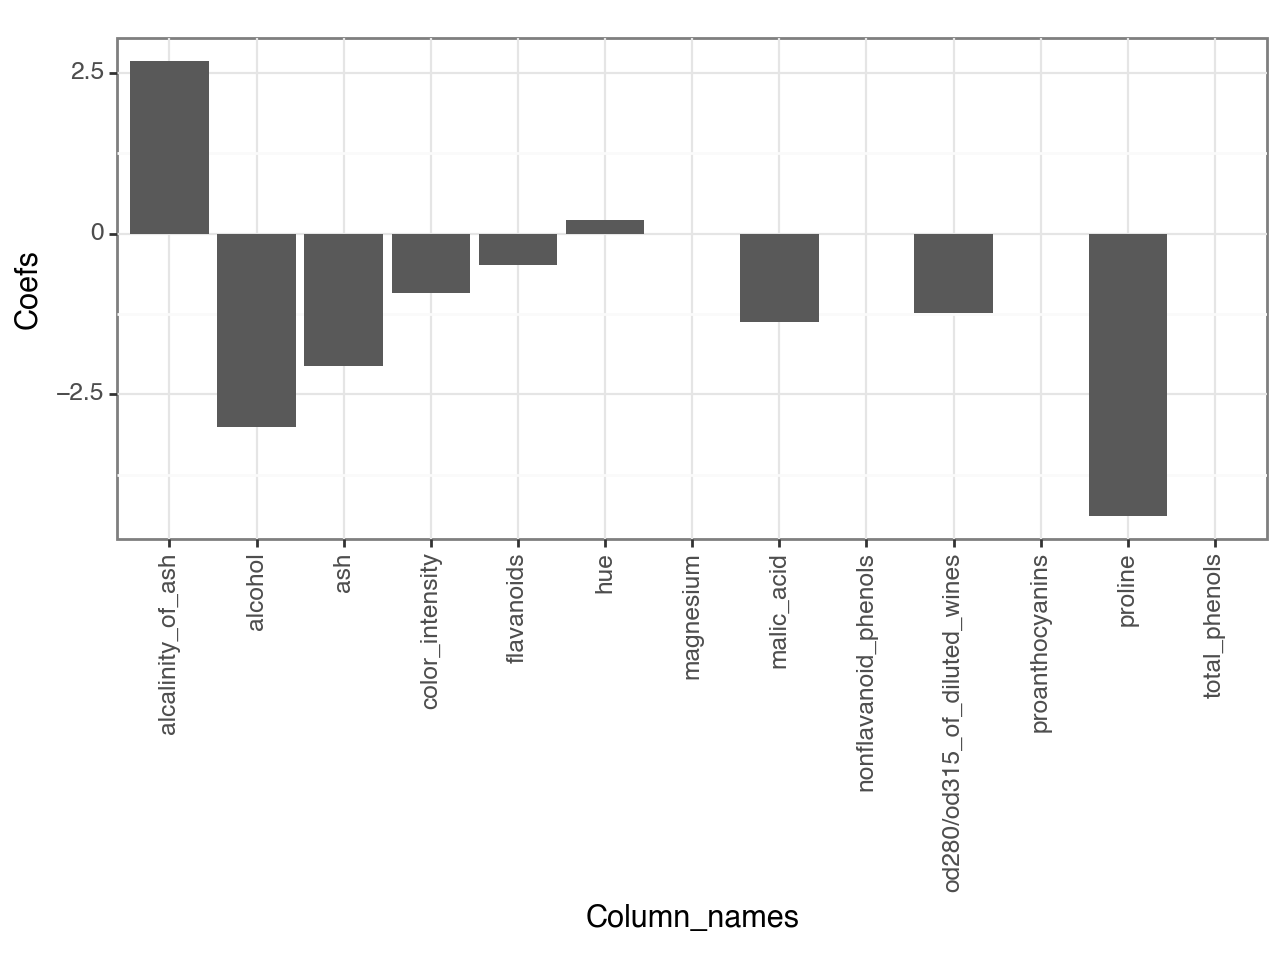

<Figure Size: (640 x 480)>

In [15]:
lg_beta = lg.coef_[0]
plot_data = pd.DataFrame({'Column_names':X.columns, 'Coefs':lg_beta})

(ggplot(data = plot_data) +
    geom_bar(stat = 'identity', mapping = aes(x = 'Column_names', y = 'Coefs')) +
    theme_bw()+
    theme(axis_text_x = element_text(angle = 90))
 # your code here
)

### Some of the variables are either being dropped or have shrunken coefficients. 

<details>
<summary>Solution</summary>
<pre>
ggplot(data = plot_data) +
    geom_bar(stat = 'identity', mapping = aes(x = 'Column_names', y = 'Coefs')) +
    theme_bw()+
    theme(axis_text_x = element_text(angle = 90))
</pre>
</details>

---

**4. Fit a model with L2 regularization to the training set using the same value of lambda as above.**  

In [16]:
# your code here
lg = LogisticRegression(C=1/lmbda, penalty='l2', solver='liblinear', max_iter=1000)
lg.fit(X_train, y_train)

LogisticRegression(C=10.0, max_iter=1000, solver='liblinear')

<details>
<summary>Solution</summary>
<pre>
lg = LogisticRegression(C=1/lmbda, penalty='l2', solver='liblinear', max_iter=1000)
lg.fit(X_train, y_train)</pre>
</details>

---

**5. Look at the performance and compare to the unregularized model AND the lasso model. How are they different?**  

In [17]:
# your code here
print(f"Accuracy: Train {100*lg.score(X_train, y_train):.0f}%, Test {100*lg.score(X_test, y_test):.0f}%")
y_proba_train = lg.predict_proba(X_train)[:,1]
y_proba_test = lg.predict_proba(X_test)[:,1]
print(f"Log loss: Train {log_loss(y_train, y_proba_train):.2f}, Test {log_loss(y_test, y_proba_test):.2f}")

Accuracy: Train 100%, Test 100%
Log loss: Train 0.01, Test 0.02


### It's very close to the lasso model.

---

**6. Visualize the coefficients and compare to the unregularized model AND the lasso model. How are they different? Why?**

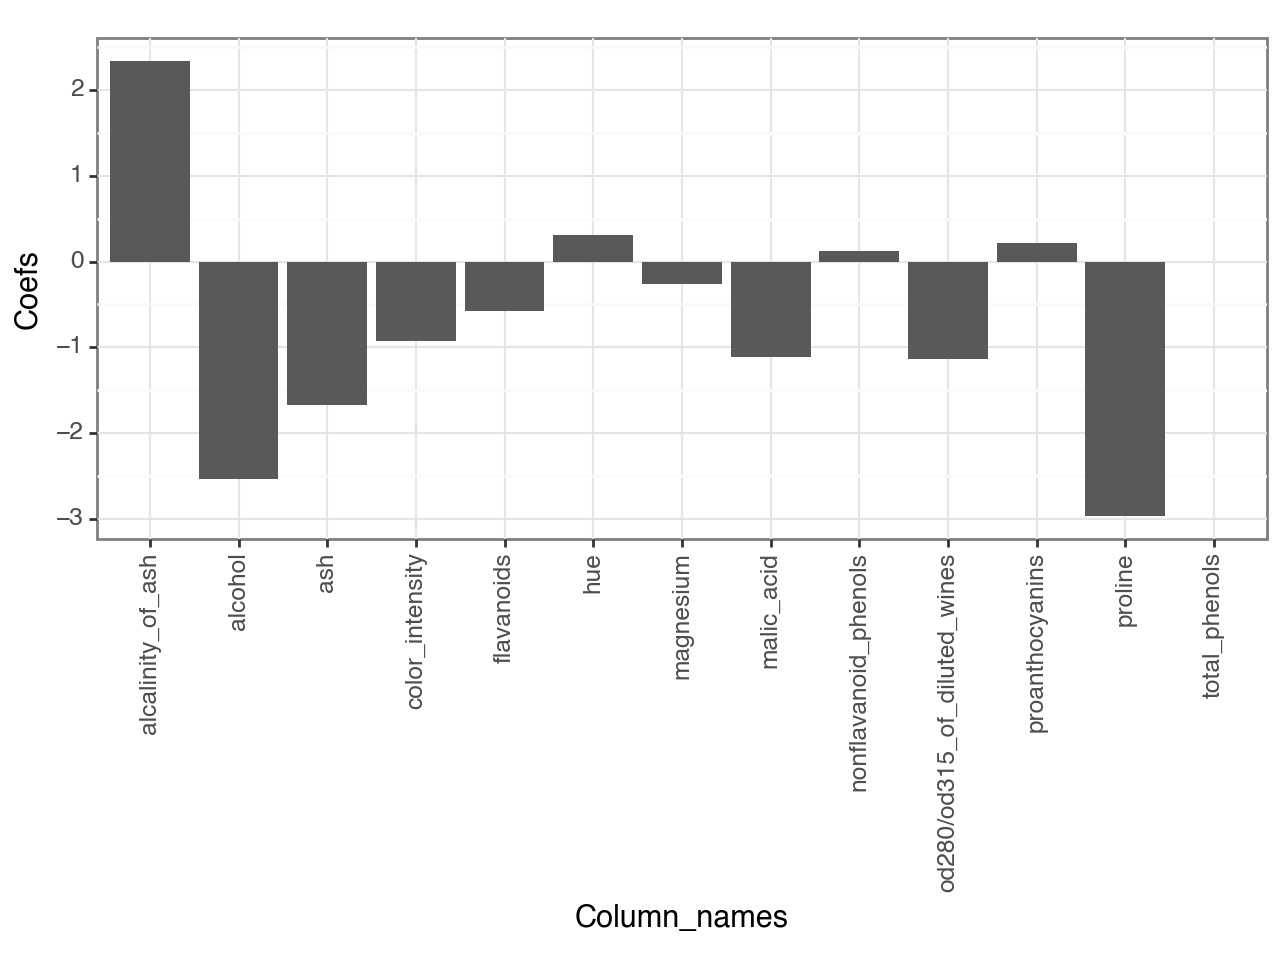

<Figure Size: (640 x 480)>

In [18]:
# your code here
lg_beta = lg.coef_[0]
plot_data = pd.DataFrame({'Column_names':X.columns, 'Coefs':lg_beta})

(
 ggplot(data = plot_data) +
    geom_bar(stat = 'identity', mapping = aes(x = 'Column_names', y = 'Coefs')) +
    theme_bw()+
    theme(axis_text_x = element_text(angle = 90))
)

### The missing coefficients were retained. This makes sense as Lasso would reduce coefficients to zero while Ridge does not.

---

### Effect of $\lambda$ on coefficients and metrics

In this section let's see what happens to our lasso model coefficients as we change $\lambda$. We'll need to fit the model multiple times and save the coefficients and log-loss metrics from each model run so we can plot them later. A `for` loop, with some numpy arrays might be the easiest way to do this. 

In [19]:
lmbda = [0.001, 0.0025, 0.005, 0.075, 0.01, 0.02, 0.03, 0.04, 0.05, 0.075, 0.1, 0.2, 0.5]
logloss_test = []
logloss_train = []
betas = np.empty([len(lmbda), X_train.shape[1]]) 
for i in range(len(lmbda)):
    lg = LogisticRegression(C=1/lmbda[i], penalty='l1', solver='liblinear', max_iter=1000)
    lg.fit(X_train, y_train)
    y_proba_train = lg.predict_proba(X_train)[:,1]
    y_proba_test = lg.predict_proba(X_test)[:,1]
    logloss_test.append(log_loss(y_test, y_proba_test))
    logloss_train.append(log_loss(y_train, y_proba_train))
    betas[i,:] = lg.coef_

And now that we've saved all of the coefficients, and the log loss values, we can make some dataframes for plotting.

In [20]:
plot_logloss_data = pd.DataFrame({'lambda':lmbda, 'logloss_test':logloss_test, 'logloss_train':logloss_train})
plot_coef_data = pd.DataFrame(betas, columns = X_train.columns)
plot_coef_data['lambda'] = lmbda
plot_coef_data

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,lambda
0,-8.936946,-2.082932,-3.581695,4.018626,0.320010,1.032159,-3.258380,-0.426709,-0.412429,-2.563039,1.737957,-1.308225,-11.044921,0.0010
1,-6.854014,-2.712734,-3.583205,4.052881,0.588288,0.089259,-2.924809,-0.315920,-0.159480,-0.071849,1.701978,-1.232641,-10.051483,0.0025
2,-5.520243,-2.739602,-3.644871,4.245808,0.257201,0.000000,-2.029330,0.000000,0.000000,-0.819700,1.051684,-1.275179,-8.922129,0.0050
3,-3.290359,-1.494786,-2.207542,2.878240,0.000000,0.000000,-0.671102,0.000000,0.000000,-0.879066,0.278377,-1.266682,-4.712844,0.0750
4,-5.341443,-2.376012,-3.207649,3.963682,0.140887,0.000000,-2.069864,0.000000,0.000000,-0.315731,0.944355,-1.263578,-7.455909,0.0100
5,-4.604301,-2.061806,-2.902465,3.671705,0.024173,0.000000,-1.508563,0.000000,0.000000,-0.651378,0.635160,-1.341787,-6.401416,0.0200
6,-4.173055,-1.875635,-2.697691,3.458168,0.000000,0.000000,-1.190826,0.000000,0.000000,-0.764172,0.494356,-1.356398,-5.834505,0.0300
7,-3.861689,-1.763493,-2.558600,3.290680,0.000000,0.000000,-0.984969,0.000000,0.000000,-0.844168,0.410341,-1.344843,-5.493061,0.0400
8,-3.692491,-1.658978,-2.420103,3.131965,0.000000,0.000000,-0.918272,0.000000,0.000000,-0.794013,0.381460,-1.297201,-5.188695,0.0500
9,-3.288916,-1.490553,-2.201873,2.873347,0.000000,0.000000,-0.671890,0.000000,0.000000,-0.866286,0.287546,-1.276153,-4.709779,0.0750


---

**1. Visualize the log loss values for the different values of $\lambda$ for the training and testing sets.**

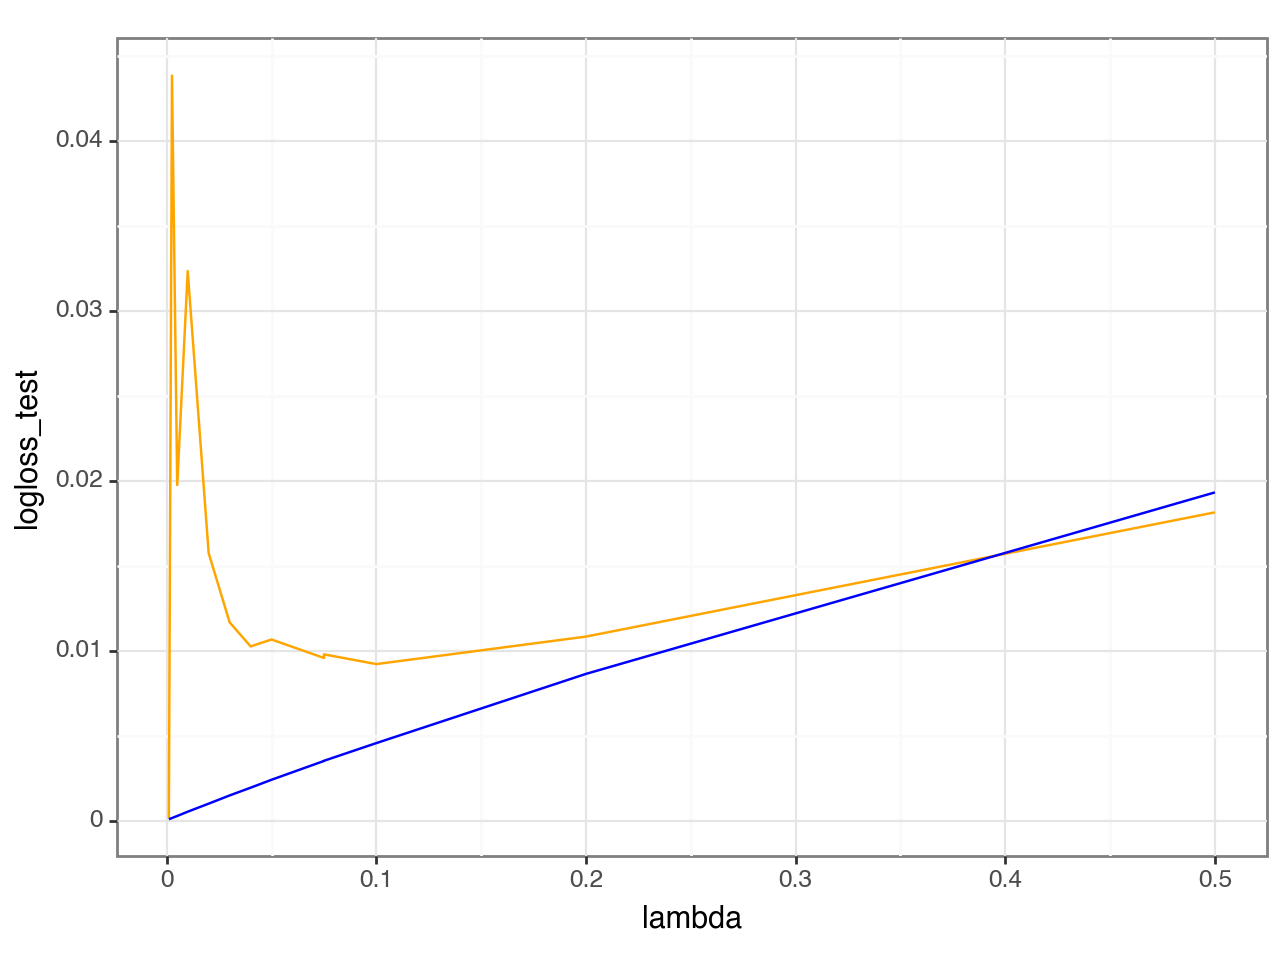

<Figure Size: (640 x 480)>

In [21]:
(
    ggplot(data = plot_logloss_data, mapping = aes(x = 'lambda', y = 'logloss_test')) +
    geom_line(color = 'orange') +
    geom_line(mapping = aes(x = 'lambda', y = 'logloss_train'), color = 'blue') + 
    theme_bw()
)

---

**2. Visualize the change in the coefficients for different values of $\lambda$**

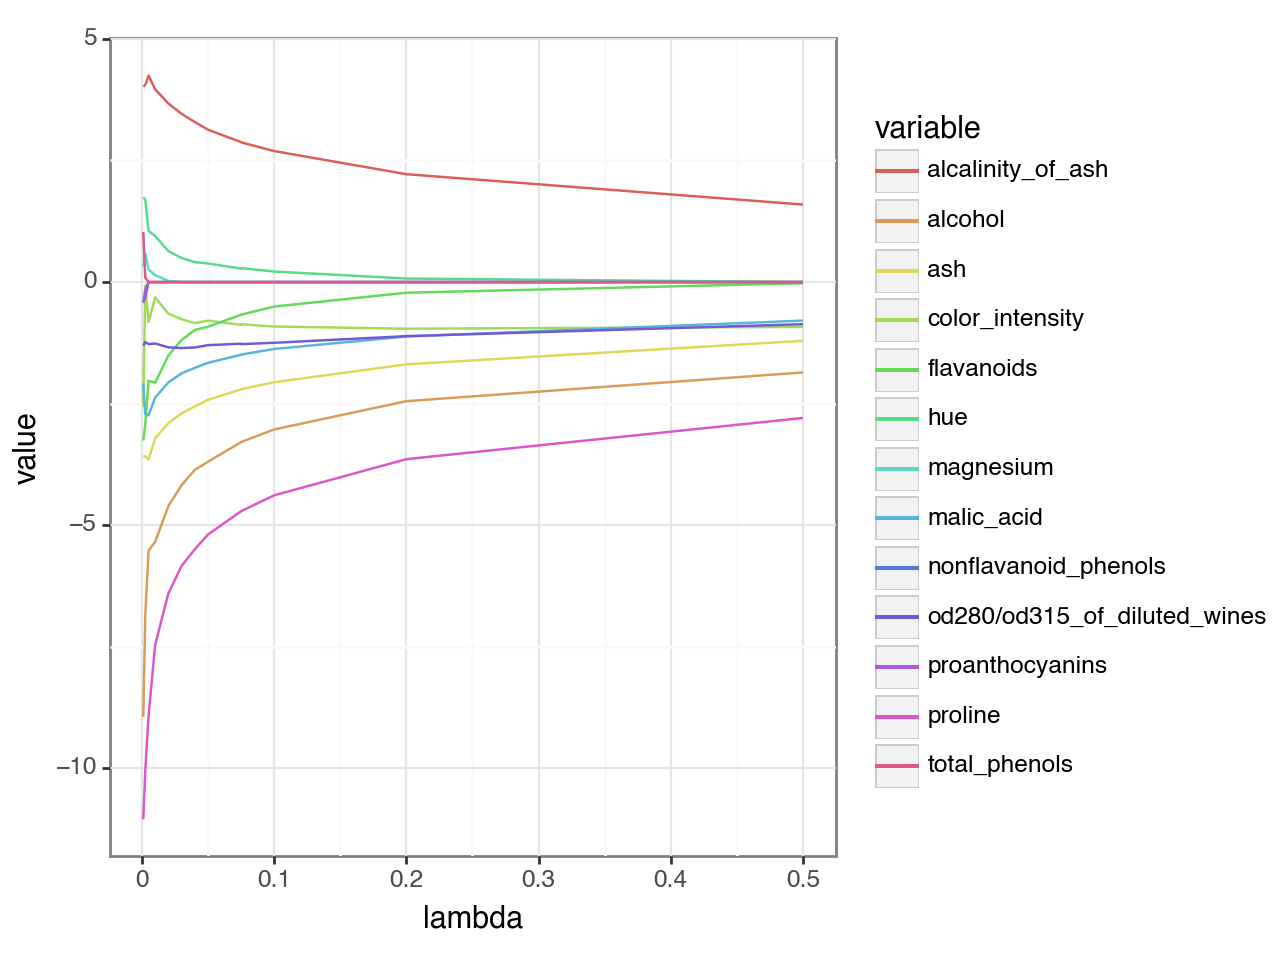

<Figure Size: (640 x 480)>

In [22]:
# Let's melt the plot_coef_data dataframe so that we can put them all on the same plot easily
plot_coef_data = plot_coef_data.melt(id_vars = 'lambda')

(
    ggplot(data = plot_coef_data, mapping = aes(x = 'lambda', y = 'value', color = 'variable')) +
    geom_line() +
    theme_bw()
)

Re-run the above with different training and test sets (if your code works you can just go to Run -> Run All Cells). You'll notice that sometimes the log loss is overall better, sometimes it's lower, but usually it's in the same ballpark. You should also notice that sometimes the testing set performance is better than the training set, and sometimes it's worse, even though you might expect regularization to always reduce overfitting and improve testing set performance. 

This is the beauty of working with real data. Not only is there randomness involved in the way you split your training and testing sets, which affects the outcome, but there may be features included in the model that should not be there.

### Let's do the same as above (Effects of $\lambda$ on coefficients and metrics), but for Ridge logistic regression instead

**1. Now do the same as above, but for ridge logistic regression.**

**2. Re-run it a few times. See what changes, see what doesn't.**

**3. Try *different* values of $\lambda$ and see how that changes the outcomes.**

In [23]:
# You can copy and past a bunch of what is above and change what you need
lmbda = [0.001, 0.0025, 0.005, 0.075, 0.01, 0.02, 0.03, 0.04, 0.05, 0.075, 0.1, 0.2, 0.5]
logloss_test = []
logloss_train = []
betas = np.empty([len(lmbda), X_train.shape[1]]) 
for i in range(len(lmbda)):
    lg = LogisticRegression(C=1/lmbda[i], penalty='l2', solver='liblinear', max_iter=1000)
    lg.fit(X_train, y_train)
    y_proba_train = lg.predict_proba(X_train)[:,1]
    y_proba_test = lg.predict_proba(X_test)[:,1]
    logloss_test.append(log_loss(y_test, y_proba_test))
    logloss_train.append(log_loss(y_train, y_proba_train))
    betas[i,:] = lg.coef_

In [24]:
plot_logloss_data = pd.DataFrame({'lambda':lmbda, 'logloss_test':logloss_test, 'logloss_train':logloss_train})
plot_coef_data = pd.DataFrame(betas, columns = X_train.columns)
plot_coef_data['lambda'] = lmbda
plot_coef_data

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,lambda
0,-5.495003,-2.942140,-4.096609,5.536231,-0.480453,-0.188525,-1.867716,0.286412,0.558545,-1.097951,0.471405,-2.127059,-7.193945,0.0010
1,-4.884606,-2.447945,-3.609873,4.874305,-0.409356,-0.193293,-1.598338,0.277343,0.474497,-1.028978,0.462886,-1.947897,-6.298714,0.0025
2,-4.368454,-2.228492,-3.169708,4.316078,-0.402172,-0.068167,-1.351096,0.233715,0.449820,-1.029155,0.447921,-1.796570,-5.568264,0.0050
3,-2.688142,-1.203677,-1.795984,2.505559,-0.268961,0.002907,-0.636598,0.135780,0.241220,-0.940667,0.326465,-1.207029,-3.184547,0.0750
4,-3.921315,-1.908841,-2.803860,3.829540,-0.363453,-0.049391,-1.152778,0.213586,0.392827,-0.999978,0.421122,-1.656669,-4.914520,0.0100
5,-3.475343,-1.641564,-2.434024,3.345303,-0.333063,-0.010684,-0.958019,0.183758,0.342501,-0.978215,0.392797,-1.508113,-4.277633,0.0200
6,-3.225154,-1.496843,-2.228246,3.073915,-0.313828,0.006042,-0.851567,0.166755,0.311668,-0.965898,0.374234,-1.418517,-3.923860,0.0300
7,-3.046183,-1.408339,-2.087668,2.890189,-0.299321,0.009692,-0.770838,0.155805,0.290822,-0.970548,0.354002,-1.354483,-3.680127,0.0400
8,-2.917110,-1.332327,-1.982140,2.750987,-0.288390,0.007920,-0.721437,0.148576,0.272627,-0.959727,0.344631,-1.302072,-3.499482,0.0500
9,-2.688142,-1.203677,-1.795984,2.505559,-0.268961,0.002907,-0.636598,0.135780,0.241220,-0.940667,0.326465,-1.207029,-3.184547,0.0750


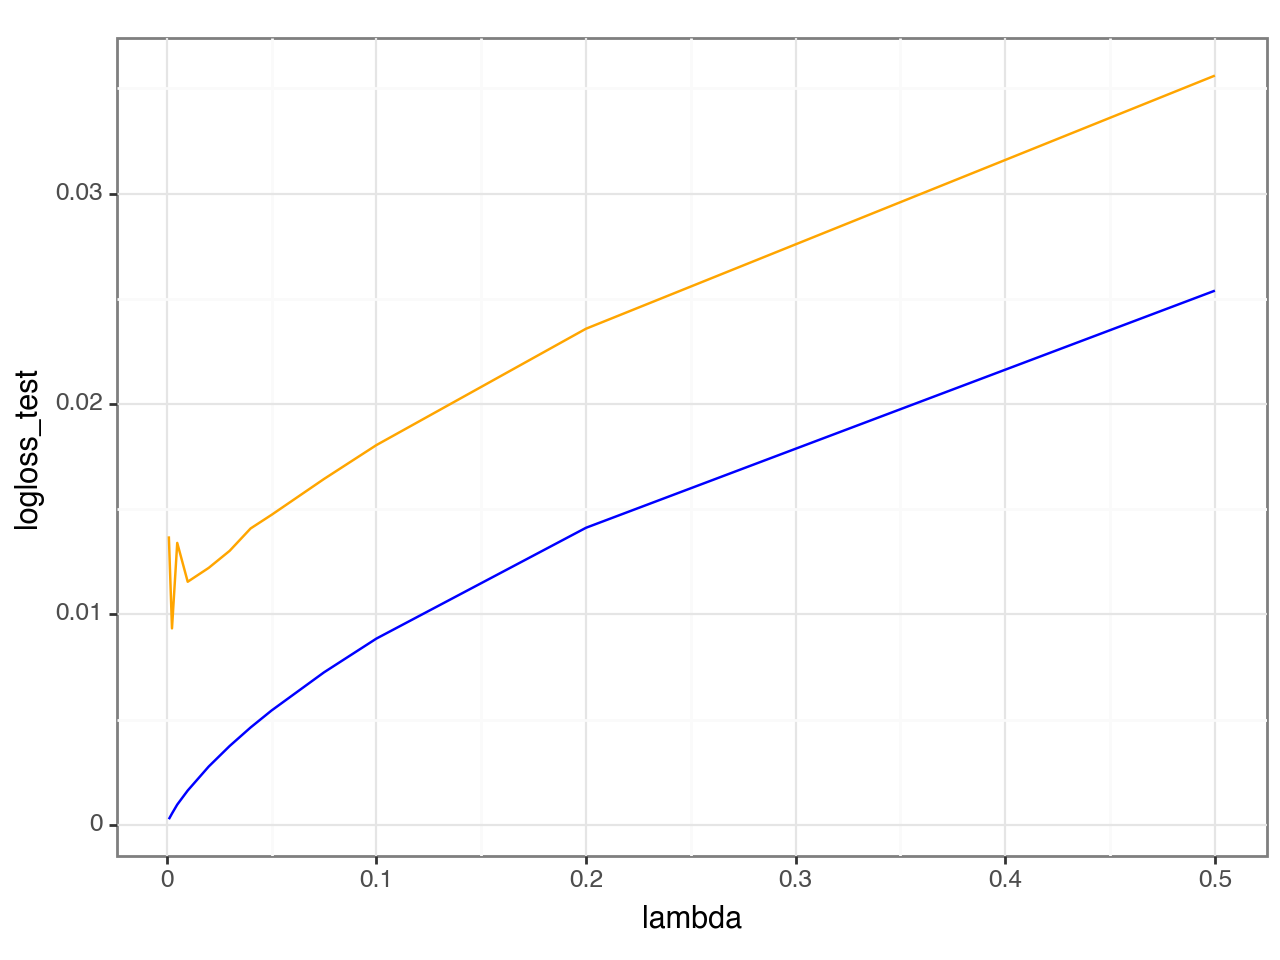

<Figure Size: (640 x 480)>

In [25]:
(
    ggplot(data = plot_logloss_data, mapping = aes(x = 'lambda', y = 'logloss_test')) +
    geom_line(color = 'orange') +
    geom_line(mapping = aes(x = 'lambda', y = 'logloss_train'), color = 'blue') + 
    theme_bw()
)

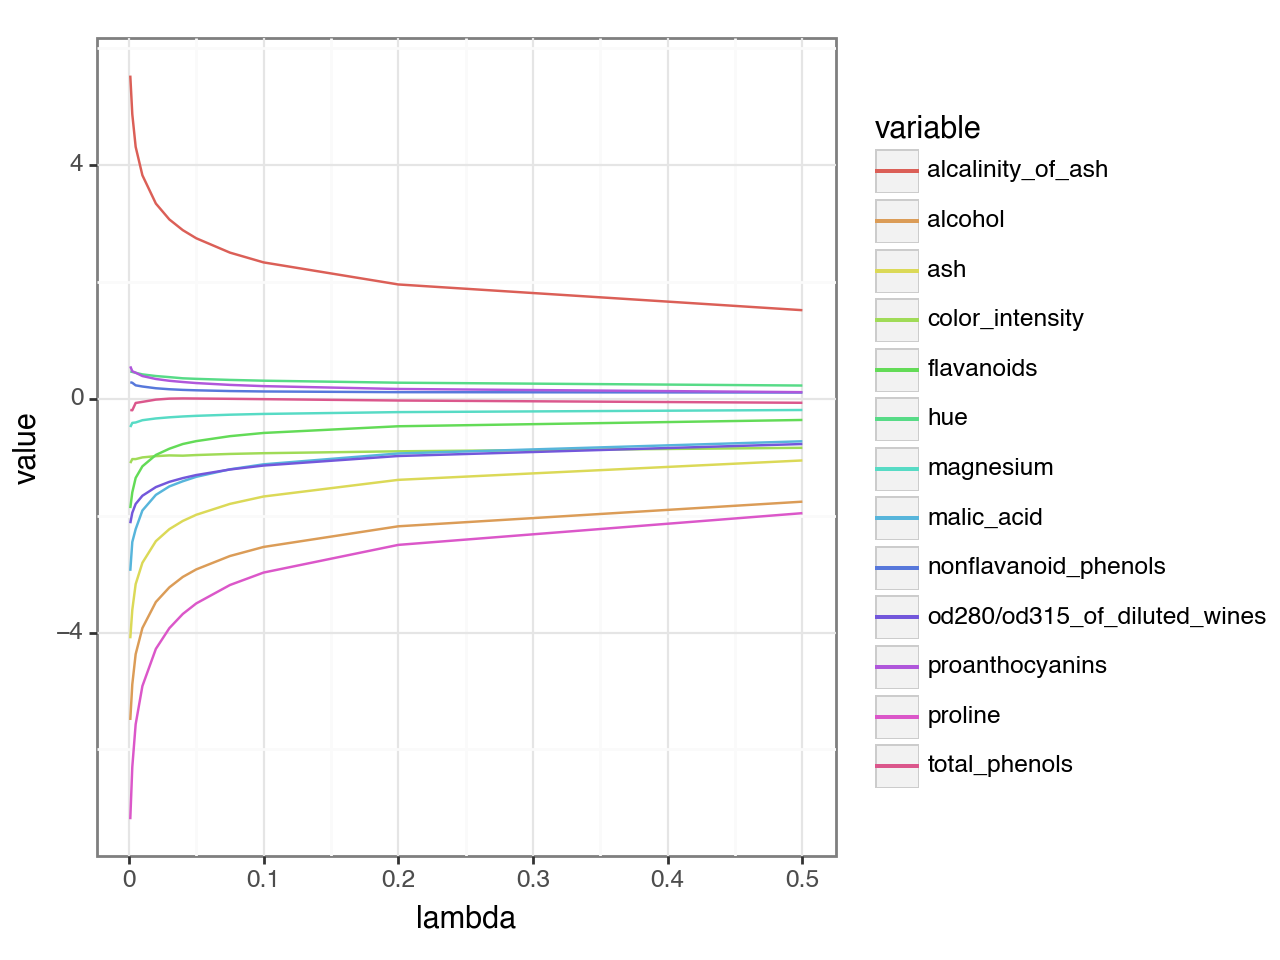

<Figure Size: (640 x 480)>

In [26]:
plot_coef_data = plot_coef_data.melt(id_vars = 'lambda')

(
    ggplot(data = plot_coef_data, mapping = aes(x = 'lambda', y = 'value', color = 'variable')) +
    geom_line() +
    theme_bw()
)